# Стратегия индексного арбитража



## Импорт библиотек

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
def hedge_ratio(y, x):
    if x.empty:
        return [0]
    model = sm.OLS(y, x)
    return model.fit()

In [ ]:
def cadf(y, x):
    # Hedge Ratio
    model = hedge_ratio(y, x)
    # Create Portfolio
    portfolio = y - model.params[0] * x
    # Perform stationarity test on portfolio
    try:
        return ts.adfuller(portfolio)
    except:
        return [0]

## Read data from CSV files

pd.read_csv is used to read the XLE and XLE stock components data from CSV file. 

In [ ]:
xle = pd.read_csv('../data_modules/xle_new.csv', index_col=0)
xle_components = pd.read_csv('../data_modules/xle_components_new.csv', parse_dates=True, index_col=0)



##Для каждого актива в файле мы найдем вероятность коинтеграции за последние 250 дней 

In [ ]:
coint_stat = pd.Series(index=xle_components.columns)
for s in xle_components.columns:
    results = cadf(list(xle.iloc[:250]['XLE']), xle_components.iloc[:250][s])
    coint_stat[s] = results[0]

print("Cointegration Results")
coint_stat.head()

Cointegration Results


APA   -2.155566
APC   -1.727793
BHI   -0.943750
BTU    0.388475
CAM    0.981605
dtype: float64

## Выбор лучших активов для коинтеграции

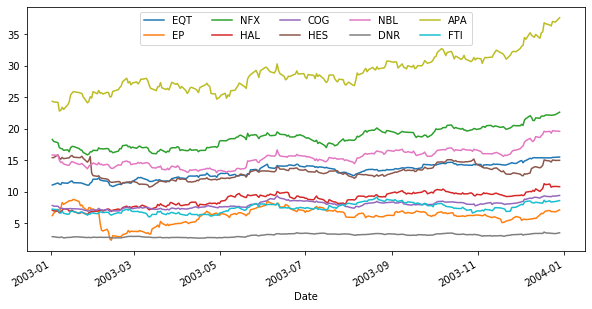

In [ ]:
# sort the stocks
coint_stat.sort_values(inplace=True)

# store top 10 stocks in stocks_to_trade
stocks_to_trade = coint_stat[:10].index

# plot the top 10 stocks price series
xle_components.iloc[:250][stocks_to_trade].plot(figsize=(10, 5))
plt.legend(loc='upper center', ncol=5)
plt.show()

## Calculate optimal hedge ratio 

Find optimal hedge ratios by regressing prices of top 10 stocks against XLE over the training set.

In [ ]:
model = hedge_ratio(list(xle.iloc[:250]['XLE']),xle_components.iloc[:250][stocks_to_trade])
model.params

EQT    0.041315
EP    -0.042257
NFX    0.068775
HAL    0.325102
COG    0.990653
HES    0.120757
NBL    0.046668
DNR   -0.220039
APA    0.089203
FTI    0.243519
dtype: float64

## Form a basket
Form a basket using these hedge ratios.

In [ ]:
basket_MV = pd.Series(index=xle_components.index, data=0.0)
for s in stocks_to_trade:
    basket_MV = basket_MV + model.params[s]*xle_components[s]

## Form a portfolio of the basket hedged with XLE

In [ ]:
basket_XLE_MV = basket_MV - xle.XLE

## Plot the spread

### In sample spread

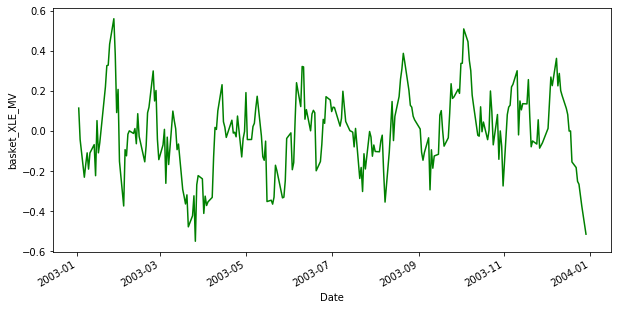

In [ ]:
#basket_XLE_MV.set_index("Date", inplace=true)
basket_XLE_MV[:250].plot(figsize=(10, 5), color='g')
plt.ylabel("basket_XLE_MV")
plt.show()

### Out of sample spread

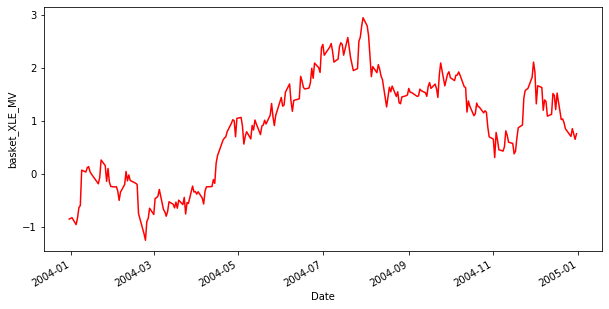

In [ ]:
basket_XLE_MV[251:].plot(figsize=(10, 5), color='r')
plt.ylabel("basket_XLE_MV")
plt.show()

The first 250 days are used to determine the hedge ratios and hence it is tightly mean reverting in that period. But in the latter half of the graph, it can be seen that the market value diverges further away before returning to the mean. Hence it is important to optimize and update the hedge ratios of the stocks at regular intervals.
